В каждой строке через пробел перечислены следующие данные:

Время, чч:мм:сс

Идентификатор трека (id)

Широта, градусы с десятичной дробной частью

Долгота, градусы с десятичной дробной частью

Высота, м

Код ответчика

Позывной


In [2]:
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from frozendict import frozendict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from boruta import BorutaPy
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import pickle
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [3]:
train = pd.read_parquet('train_feat_ts.parquet', engine='pyarrow')
test = pd.read_parquet('test_feat_ts.parquet', engine='pyarrow')

In [4]:
train.columns=train.columns.str.replace('[#,@,&,",/]','')
test.columns=test.columns.str.replace('[#,@,&,",/]','')

The default value of regex will change from True to False in a future version.
The default value of regex will change from True to False in a future version.


In [8]:
train.columns

Index(['track_id', 'latitude', 'longitude', 'height', 'code', 'name', 'period',
       'time_from_start', 'diff_1_time_from_start', 'diff_3_time_from_start',
       ...
       'diff_10_heightsec__linear_trend__attr_pvalue',
       'diff_10_heightsec__linear_trend__attr_stderr',
       'diff_10_heightsec__augmented_dickey_fuller__attr_teststat__autolag_AIC',
       'diff_10_heightsec__augmented_dickey_fuller__attr_pvalue__autolag_AIC',
       'diff_10_heightsec__augmented_dickey_fuller__attr_usedlag__autolag_AIC',
       'diff_10_heightsec__ratio_beyond_r_sigma__r_0.5',
       'diff_10_heightsec__ratio_beyond_r_sigma__r_1.5',
       'diff_10_heightsec__ratio_beyond_r_sigma__r_2',
       'diff_10_heightsec__ratio_beyond_r_sigma__r_2.5', 'target'],
      dtype='object', length=872)

In [5]:
columns_to_not_use = ['latitude', 'longitude', 'height',
                'period','time_from_start','track_id',  'period','code', 
               'time_from_start','name',
               'diff_1_height', 'diff_3_height',
               'diff_10_height', 'diff_1_longitude', 'diff_3_longitude',
               'diff_10_longitude', 'diff_1_latitude', 'diff_3_latitude',
               'diff_10_latitude', 'target', 'full_id', 'index']


In [9]:
clf = lgb.LGBMClassifier(max_depth=10, 
                         num_leaves=1000,
                         random_state=69, 
                         metric='AUC', 
                         n_jobs=8, 
                         reg_lambda=3,
                         reg_alpha=2,
                         n_estimators=1000,
                         learning_rate=0.01)

clf.fit(train.drop(columns_to_not_use, axis=1), 
          train.target)

LGBMClassifier(learning_rate=0.01, max_depth=10, metric='AUC',
               n_estimators=1000, n_jobs=8, num_leaves=1000, random_state=69,
               reg_alpha=2, reg_lambda=3)

In [10]:
predictions = clf.predict(test.drop(columns_to_not_use, axis=1))
print(classification_report(test.target, predictions))

In [11]:
print(classification_report(test.target, predictions))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89    335158
           1       0.96      0.87      0.91    472886

    accuracy                           0.90    808044
   macro avg       0.90      0.91      0.90    808044
weighted avg       0.91      0.90      0.90    808044



In [12]:
confusion_matrix(test.target, predictions)

array([[316962,  18196],
       [ 63275, 409611]])

In [13]:
df_res = test[['name','track_id', 'target']].copy()
df_res['result'] = predictions

In [14]:
y_true = df_res.groupby(['name','track_id']).target.max()
y_pred = df_res.groupby(['name','track_id']).result.max()

In [15]:
confusion_matrix(y_true, y_pred)

array([[658,  24],
       [ 84, 786]])

In [17]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       682
           1       0.97      0.90      0.94       870

    accuracy                           0.93      1552
   macro avg       0.93      0.93      0.93      1552
weighted avg       0.93      0.93      0.93      1552



In [13]:
cols = test.drop(columns_to_not_use, axis=1).columns

In [34]:
def plotImp(model, cols , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_, 'Feature': cols})
    
    plt.figure(figsize=(7, 15))
    sns.set(font_scale = 1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    
    plt.show()

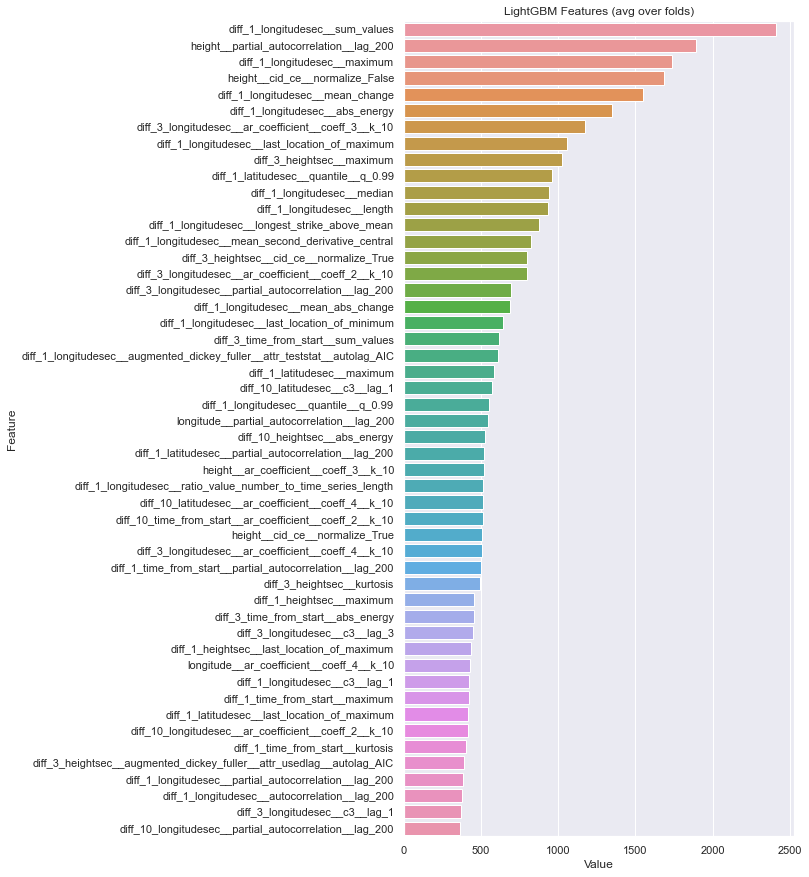

In [35]:
plotImp(clf, cols , num = 50)

In [37]:
pickle.dump(clf, open("lightgbm_big.pkl", "wb"))

In [10]:
clf = pickle.load(open("lightgbm_big.pkl", "rb"))

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(test.drop(columns_to_not_use, axis=1))


In [14]:
feature_imp = pd.DataFrame({'Value':clf.feature_importances_, 'Feature': cols})


In [15]:
feature_imp.to_csv('feature_importance.csv', index=False)

In [27]:
feature_imp = pd.read_csv('feature_importance.csv')

In [28]:
columns_to_use = feature_imp.sort_values(by="Value", ascending=False)[0:100]

In [29]:
columns_to_not_use = feature_imp.sort_values(by="Value", ascending=False)[100:].Feature.values

In [30]:
y_train = train.target
train.drop(columns_to_not_use, axis=1, inplace=True)
y_test = test.target
test.drop(columns_to_not_use, axis=1, inplace=True)

In [36]:
columns_to_not_use = ['latitude', 'longitude', 'height',
                'period','time_from_start','track_id',  'period','code', 
               'time_from_start','name',
               'diff_1_height', 'diff_3_height',
               'diff_10_height', 'diff_1_longitude', 'diff_3_longitude',
               'diff_10_longitude', 'diff_1_latitude', 'diff_3_latitude',
               'diff_10_latitude', 'target', 'full_id', 'index', 'height__cid_ce__normalize_False']

In [37]:
clf = lgb.LGBMClassifier(max_depth=4, 
                         num_leaves=14,
                         random_state=69, 
                         metric='AUC', 
                         n_jobs=8, 
                         reg_lambda=3,
                         reg_alpha=2,
                         n_estimators=150,
                         learning_rate=0.01)

clf.fit(train.drop(columns_to_not_use, axis=1), 
        train.target)

LGBMClassifier(learning_rate=0.01, max_depth=4, metric='AUC', n_estimators=150,
               n_jobs=8, num_leaves=14, random_state=69, reg_alpha=2,
               reg_lambda=3)

In [76]:
predictions = clf.predict(test.drop(columns_to_not_use, axis=1))
print(classification_report(test.target, predictions))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87    335158
           1       0.96      0.84      0.89    472886

    accuracy                           0.88    808044
   macro avg       0.88      0.89      0.88    808044
weighted avg       0.90      0.88      0.88    808044



In [39]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(test.drop(columns_to_not_use, axis=1))


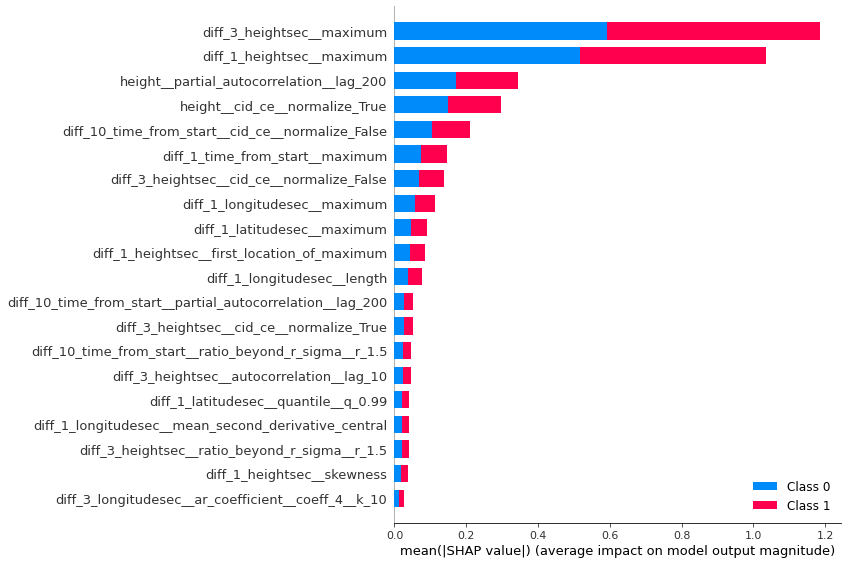

In [103]:
shap.summary_plot(shap_values, test.drop(columns_to_not_use, axis=1),show=False)
plt.savefig("summary_plot.jpg")

In [52]:
df_res = test[['name','track_id', 'target']].copy()
df_res['result_proba'] = clf.predict_proba(test.drop(columns_to_not_use, axis=1))[:,1]
df_res['result'] = predictions

In [79]:
df_res.to_csv('result.csv', index=False)

In [77]:
df_res.to_csv('result.csv', index=False)
y_true = df_res.groupby(['name','track_id']).target.max()
y_pred = df_res.groupby(['name','track_id']).result.max()

In [88]:
confusion_matrix(y_true, y_pred)

array([[655,  27],
       [101, 769]])

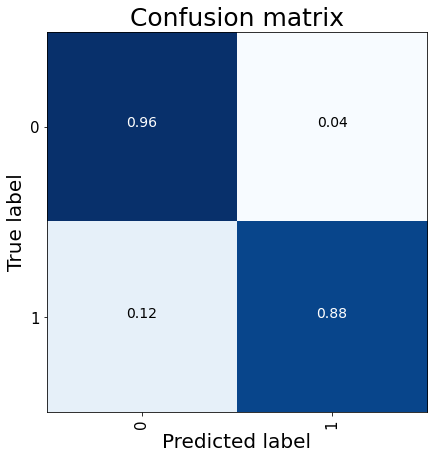

In [80]:
cnf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=[0, 1], title="Confusion matrix")
plt.show()

In [70]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)